In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.join('../'))))

In [1]:
import numpy
import torchvision

train = torchvision.datasets.MNIST('mnist', train = True, download = False)
test = torchvision.datasets.MNIST('mnist', train = False, download = False)

train_images = numpy.array([ numpy.array(item[0]) for item in train ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ numpy.array(item[0]) for item in test ])
test_labels = numpy.array([ item[1] for item in test ])

In [3]:
import gc

import numpy
import itertools
import cvtda.utils
import cvtda.topology

In [4]:
BINARIZER_THRESHOLD = 0.1

### Inverter

In [5]:
import gtda.images

inverter = gtda.images.Inverter(n_jobs = -1).fit(train_images)
train_images = inverter.transform(train_images)
test_images = inverter.transform(test_images)

BINARIZER_THRESHOLD = 0.9

### Sobel filter

In [5]:
import torch

def apply_sobel_filter(images: numpy.ndarray) -> numpy.ndarray:
    # https://en.wikipedia.org/wiki/Sobel_operator
    # https://en.wikipedia.org/wiki/Roberts_cross
    # https://en.wikipedia.org/wiki/Prewitt_operator
    sobel_hor = [
        [1., 2, 1], 
        [0, 0, 0], 
        [-1, -2, -1]
    ]

    sobel_ver = [
        [1, 0, -1], 
        [2, 0, -2], 
        [1, 0, -1]
    ]

    sobel_hor = torch.tensor([[sobel_hor]], dtype = torch.float32)
    sobel_ver = torch.tensor([[sobel_ver]], dtype = torch.float32)

    images = torch.tensor(images, dtype = torch.float32).unsqueeze(dim = 1)

    img_conv_hor = torch.nn.functional.conv2d(images, sobel_hor, padding = 1)
    img_conv_vet = torch.nn.functional.conv2d(images, sobel_ver, padding = 1)

    images = torch.sqrt(img_conv_hor ** 2 + img_conv_vet ** 2)
    return images.squeeze(dim = 1).numpy()

train_images = apply_sobel_filter(train_images)
test_images = apply_sobel_filter(test_images)

train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

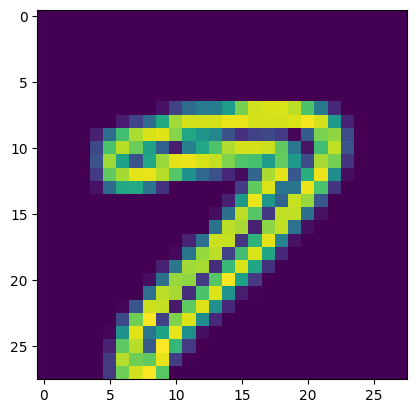

In [6]:
import matplotlib.pyplot as plt

plt.imshow(train_images[123])

### Greyscale To smth

In [7]:
greyscale_to_filtrations = cvtda.topology.GreyscaleToFiltrations(
    binarizer_threshold = BINARIZER_THRESHOLD,
    radial_filtration_centers=list(itertools.product([ 3, 8, 13, 18, 23 ], [ 3, 8, 13, 18, 23 ]))
)

train_filtrations = greyscale_to_filtrations.fit_transform(train_images)
test_filtrations = greyscale_to_filtrations.transform(test_images)

train_filtrations.shape, test_filtrations.shape

Fitting the binarizer


Fitting the filtrations: 100%|██████████| 38/38 [00:00<00:00, 2914.26it/s]


Fitting complete


Filtrations: 100%|██████████| 38/38 [00:06<00:00,  6.03it/s]


((60000, 39, 28, 28), (10000, 39, 28, 28))

In [8]:
greyscale_to_pointclouds = cvtda.topology.GreyscaleToPointClouds(binarizer_threshold = BINARIZER_THRESHOLD)

train_pointclouds = greyscale_to_pointclouds.fit_transform(train_images)
test_pointclouds = greyscale_to_pointclouds.transform(test_images)

len(train_pointclouds[0][1]), len(test_pointclouds)

Fitting the binarizer
Fitting the converter
Fitting image_to_point_cloud
Fitting complete
Applying the binarizer


Converting images to point clouds: 100%|██████████| 60000/60000 [00:01<00:00, 44476.69it/s]


Converting binary to point clouds


Combining the point clouds:   0%|          | 0/60000 [00:00<?, ?it/s]

Applying the binarizer


Converting images to point clouds: 100%|██████████| 10000/10000 [00:00<00:00, 53873.97it/s]


Converting binary to point clouds


Combining the point clouds:   0%|          | 0/10000 [00:00<?, ?it/s]

(239, 10000)

In [5]:
del train_images
del test_images
gc.collect()

21

### Flatten

In [10]:
filtrations_flatten = cvtda.utils.FlattenBatch()

train_filtrations = filtrations_flatten.fit_transform(train_filtrations)
test_filtrations = filtrations_flatten.transform(test_filtrations)

train_filtrations.shape

(2340000, 28, 28)

In [11]:
pointclouds_flatten = cvtda.utils.FlattenBatch()

train_pointclouds = pointclouds_flatten.fit_transform(train_pointclouds)
test_pointclouds = pointclouds_flatten.transform(test_pointclouds)

len(train_pointclouds)

120000

### Diagrams

In [12]:
filtrations_to_diagrams = cvtda.topology.FiltrationsToDiagrams()

train_filtration_diagrams = filtrations_to_diagrams.fit_transform(train_filtrations)
numpy.save("6/train_filtration_diagrams.npy", train_filtration_diagrams)
train_filtration_diagrams = numpy.load("6/train_filtration_diagrams.npy")

test_filtration_diagrams = filtrations_to_diagrams.transform(test_filtrations)
numpy.save("6/test_filtration_diagrams.npy", test_filtration_diagrams)
test_filtration_diagrams = numpy.load("6/test_filtration_diagrams.npy")

train_filtration_diagrams.shape, test_filtration_diagrams.shape

Fitting the persistence


d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting complete
Calculating the persistence


d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Calculating the persistence


d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


((2340000, 52, 3), (390000, 51, 3))

In [13]:
del train_filtrations
del test_filtrations
gc.collect()

42

In [ ]:
pointclouds_to_diagrams = cvtda.topology.PointCloudsToDiagrams()

train_pointcloud_diagrams = pointclouds_to_diagrams.fit_transform(train_pointclouds)
numpy.save("6/train_pointcloud_diagrams.npy", train_pointcloud_diagrams)
train_pointcloud_diagrams = numpy.load("6/train_pointcloud_diagrams.npy")

test_pointcloud_diagrams = pointclouds_to_diagrams.transform(test_pointclouds)
numpy.save("6/test_pointcloud_diagrams.npy", test_pointcloud_diagrams)
test_pointcloud_diagrams = numpy.load("6/test_pointcloud_diagrams.npy")

train_pointcloud_diagrams.shape, test_pointcloud_diagrams.shape

In [15]:
del train_pointclouds
del test_pointclouds
gc.collect()

42

### Features

In [16]:
filtration_features = cvtda.topology.DiagramsToFeatures(n_bins = 32)

train_filtration_features = filtration_features.fit_transform(train_filtration_diagrams)
numpy.save("6/train_filtration_features.npy", train_filtration_features)
train_filtration_features = numpy.load("6/train_filtration_features.npy")

test_filtration_features = filtration_features.transform(test_filtration_diagrams)
numpy.save("6/test_filtration_features.npy", test_filtration_features)
test_filtration_features = numpy.load("6/test_filtration_features.npy")

train_filtration_features.shape, test_filtration_features.shape

Fitting the calculator
Fitting the filtering


d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting the betti curve


d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting the persistence landscape


d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the silhouettes:   0%|          | 0/2 [00:00<?, ?it/s]d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the silhouettes:  50%|█████     | 1/2 [00:06<00:06,  6.83s/it]d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the silhouettes: 100%|██████████| 2/2 [00:13<00:00,  6.74s/it]
d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8

Fitting the persistence entropy
Fitting the number of points


d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the heat kernels:   0%|          | 0/3 [00:00<?, ?it/s]d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the heat kernels:  33%|███▎      | 1/3 [00:06<00:13,  6.72s/it]d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the heat kernels:  67%|██████▋   | 2/3 [00:13<00:06,  6.73s/it]d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1

Fitting complete


Batch:   0%|          | 1/572 [00:14<2:15:56, 14.28s/it]d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Batch: 100%|██████████| 96/96 [01:00<00:00,  1.58it/s]


((2340000, 260), (390000, 260))

In [17]:
del train_filtration_diagrams
del test_filtration_diagrams
gc.collect()

73

In [18]:
pointcloud_features = cvtda.topology.DiagramsToFeatures(batch_size = 256)

train_pointcloud_features = pointcloud_features.fit_transform(train_pointcloud_diagrams)
numpy.save("6/train_pointcloud_features.npy", train_pointcloud_features)
train_pointcloud_features = numpy.load("6/train_pointcloud_features.npy")

test_pointcloud_features = pointcloud_features.transform(test_pointcloud_diagrams)
numpy.save("6/test_pointcloud_features.npy", test_pointcloud_features)
test_pointcloud_features = numpy.load("6/test_pointcloud_features.npy")

train_pointcloud_features.shape, test_pointcloud_features.shape

Fitting the calculator
Fitting the filtering


d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting the betti curve


d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting the persistence landscape


d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the silhouettes:   0%|          | 0/2 [00:00<?, ?it/s]d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the silhouettes:  50%|█████     | 1/2 [00:04<00:04,  4.16s/it]d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the silhouettes: 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]
d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8

Fitting the persistence entropy
Fitting the number of points


d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the heat kernels:   0%|          | 0/3 [00:00<?, ?it/s]d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the heat kernels:  33%|███▎      | 1/3 [00:04<00:08,  4.13s/it]d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Fitting the heat kernels:  67%|██████▋   | 2/3 [00:08<00:04,  4.14s/it]d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1

Fitting complete


Batch: 100%|██████████| 79/79 [00:39<00:00,  1.99it/s]


((120000, 260), (20000, 260))

In [19]:
del train_pointcloud_diagrams
del test_pointcloud_diagrams
gc.collect()

73

In [20]:
train_filtration_features = numpy.load("6/train_filtration_features.npy")
train_pointcloud_features = numpy.load("6/train_pointcloud_features.npy")

test_pointcloud_features = numpy.load("6/test_pointcloud_features.npy")
test_filtration_features = numpy.load("6/test_filtration_features.npy")

### Unflat

In [21]:
train_filtration_features = filtrations_flatten.inverse_transform(train_filtration_features)
test_filtration_features = filtrations_flatten.inverse_transform(test_filtration_features)

train_filtration_features.shape

(60000, 39, 260)

In [22]:
train_pointcloud_features = pointclouds_flatten.inverse_transform(train_pointcloud_features)
test_pointcloud_features = pointclouds_flatten.inverse_transform(test_pointcloud_features)

train_pointcloud_features.shape

(60000, 2, 260)

In [23]:
train_features = numpy.hstack([
    train_filtration_features.reshape((len(train_filtration_features), -1)),
    train_pointcloud_features.reshape((len(train_pointcloud_features), -1))
])
numpy.save("6/train_features.npy", train_features)
train_features = numpy.load("6/train_features.npy")

test_features = numpy.hstack([
    test_filtration_features.reshape((len(test_filtration_features), -1)),
    test_pointcloud_features.reshape((len(test_pointcloud_features), -1))
])
numpy.save("6/test_features.npy", test_features)
test_features = numpy.load("6/test_features.npy")

train_features.shape, test_features.shape

((60000, 10660), (10000, 10660))

In [24]:
del train_filtration_features
del train_pointcloud_features

del test_filtration_features
del test_pointcloud_features

gc.collect()

0

In [25]:
train_features = numpy.load("6/train_features.npy")
test_features = numpy.load("6/test_features.npy")

train_features.shape, test_features.shape

((60000, 10660), (10000, 10660))

### Classifier

In [26]:
import cvtda.classification
train_features = numpy.minimum(train_features, 1e9)
test_features = numpy.minimum(test_features, 1e9)

#### Raw features

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(max_features=0.1, random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x0000019F0FA008B0>


100%|██████████| 50/50 [00:50<00:00,  1.02s/it, loss=9.8e+4] 


Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


d:\Programs\Programming\Python\lib\site-packages\xgboost\core.py:158: UserWarning: [13:04:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.6979,0.8301,0.8871,0.9245,0.9477,0.9639,0.9758,0.9882,0.9965,0.927926,0.693388,0.691303,0.688465
1,DecisionTreeClassifier,0.8465,0.8694,0.8988,0.9119,0.9296,0.9472,0.9614,0.9826,0.9881,0.913664,0.844704,0.844595,0.844619
2,RandomForestClassifier,0.9185,0.9680,0.9839,0.9898,0.9948,0.9968,0.9986,0.9994,0.9999,0.993830,0.917918,0.917348,0.917507
3,NNClassifier,0.8286,0.8703,0.8802,0.8858,0.8901,0.8937,0.8967,0.8997,0.9285,0.943118,0.756286,0.828677,0.787339
4,HistGradientBoostingClassifier,0.8946,0.9582,0.9758,0.9856,0.9923,0.9958,0.9976,0.9989,0.9998,0.991471,0.893778,0.893270,0.893355
5,XGBClassifier,0.9122,0.9687,0.9843,0.9917,0.9954,0.9973,0.9986,0.9994,0.9998,0.994217,0.911063,0.911059,0.910975


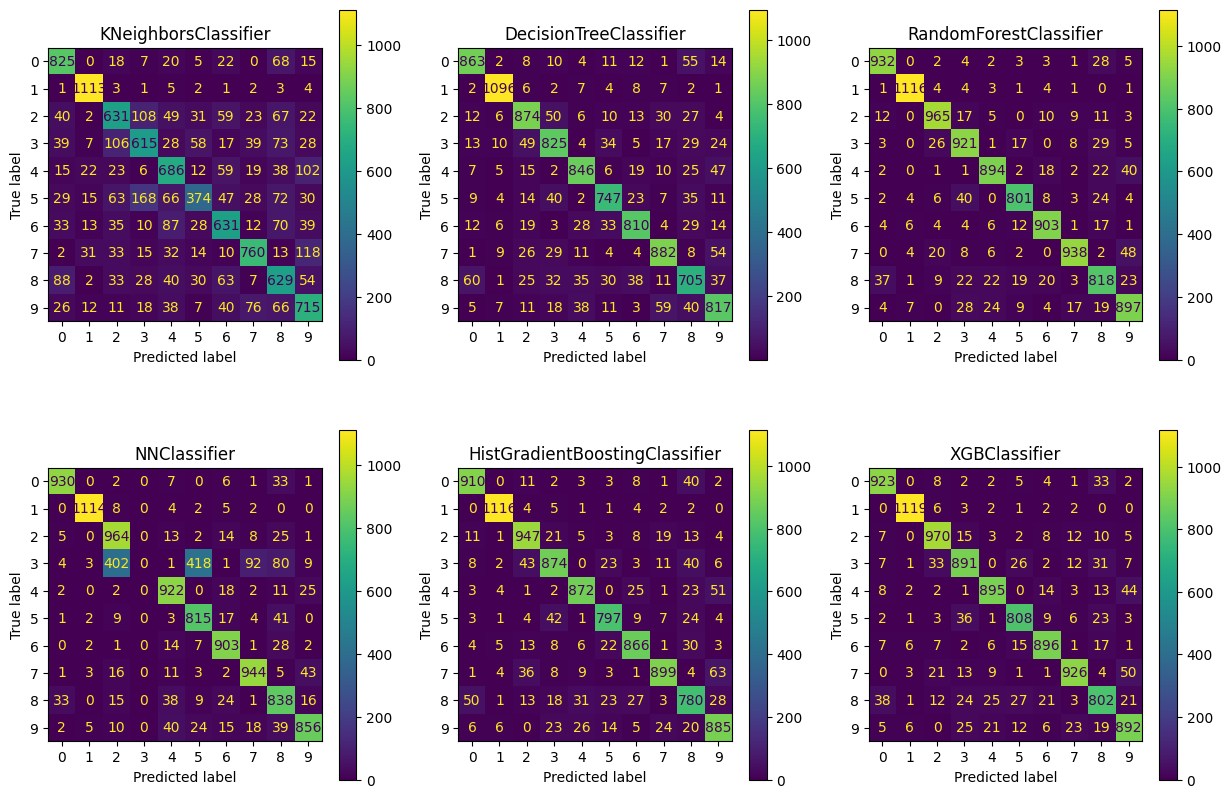

In [27]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

#### StandardScaler

In [28]:
import sklearn.preprocessing

standard_scaler = sklearn.preprocessing.StandardScaler()
train_features_scaled = standard_scaler.fit_transform(train_features)
test_features_scaled = standard_scaler.transform(test_features)

In [29]:
del train_features
del test_features
gc.collect()

77033

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(max_features=0.1, random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x0000019F50412080>


100%|██████████| 50/50 [00:57<00:00,  1.14s/it, loss=8.94e+4]


Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.8613,0.9352,0.9594,0.9720,0.9791,0.9840,0.9903,0.9954,0.9985,0.975409,0.863207,0.859267,0.859693
1,DecisionTreeClassifier,0.8430,0.8665,0.8988,0.9130,0.9293,0.9483,0.9640,0.9826,0.9887,0.911749,0.840672,0.841149,0.840789
2,RandomForestClassifier,0.9170,0.9665,0.9838,0.9906,0.9954,0.9971,0.9982,0.9996,0.9999,0.993888,0.916391,0.915791,0.915943
3,NNClassifier,0.9300,0.9718,0.9846,0.9902,0.9940,0.9972,0.9984,0.9991,0.9997,0.994789,0.929931,0.929050,0.929238
4,HistGradientBoostingClassifier,0.8925,0.9558,0.9763,0.9857,0.9920,0.9948,0.9969,0.9989,0.9997,0.991432,0.891440,0.891193,0.891169
5,XGBClassifier,0.9130,0.9682,0.9848,0.9922,0.9952,0.9971,0.9985,0.9992,0.9997,0.994287,0.911927,0.911752,0.911738


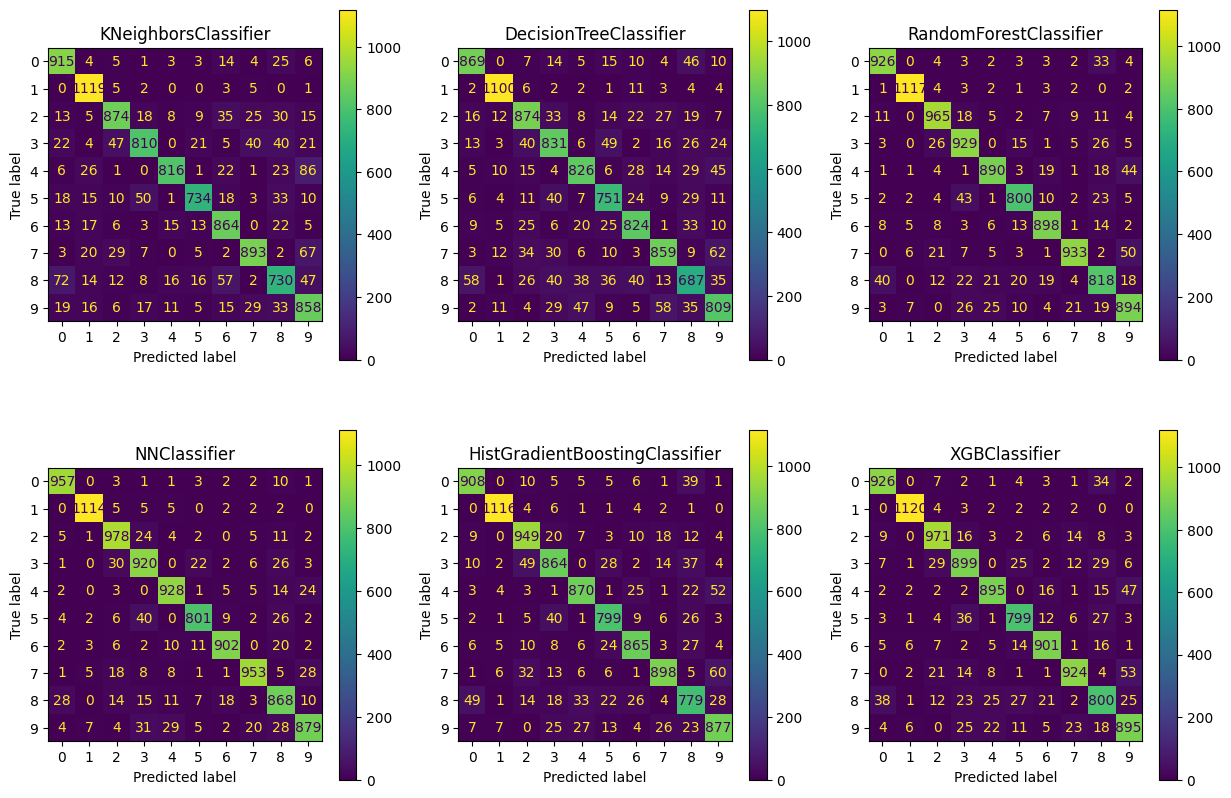

In [30]:
cvtda.classification.classify(
    train_features_scaled, train_labels, test_features_scaled, test_labels
)

#### PCA

In [39]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 128, random_state = 42)

train_features_pca = pca.fit_transform(train_features_scaled)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])

test_features_pca = pca.transform(test_features_scaled)

Explained variance 0.87
[0.247, 0.155, 0.054, 0.038, 0.031, 0.028, 0.025, 0.018, 0.017, 0.015, 0.014, 0.013, 0.011, 0.011, 0.008, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(max_features=0.1, random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x000001A145F26D70>


100%|██████████| 50/50 [00:20<00:00,  2.40it/s, loss=8.82e+4]


Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.9553,0.9809,0.9883,0.9917,0.9932,0.9950,0.9963,0.9980,0.9991,0.994580,0.955295,0.954762,0.954894
1,DecisionTreeClassifier,0.8239,0.8508,0.8718,0.8889,0.9064,0.9317,0.9480,0.9801,0.9882,0.901201,0.821858,0.822162,0.821894
2,RandomForestClassifier,0.9505,0.9819,0.9899,0.9938,0.9964,0.9975,0.9983,0.9990,0.9996,0.997685,0.950180,0.949966,0.950004
3,NNClassifier,0.9749,0.9918,0.9960,0.9971,0.9982,0.9987,0.9990,0.9995,0.9999,0.998334,0.974997,0.974661,0.974805
4,HistGradientBoostingClassifier,0.9170,0.9684,0.9820,0.9904,0.9936,0.9965,0.9980,0.9990,0.9997,0.994530,0.916843,0.916152,0.916223
5,XGBClassifier,0.9475,0.9802,0.9894,0.9938,0.9966,0.9978,0.9990,0.9996,0.9998,0.997809,0.947141,0.946861,0.946979


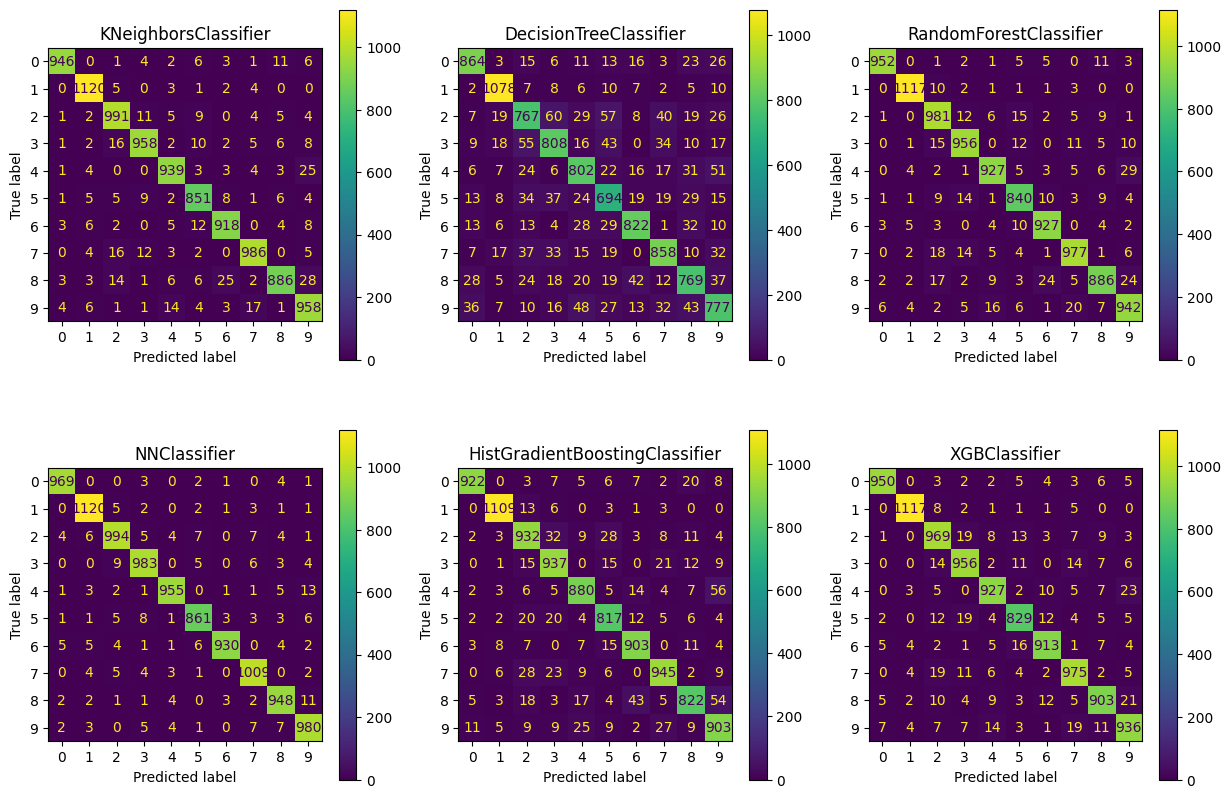

In [40]:
cvtda.classification.classify(
    train_features_pca, train_labels, test_features_pca, test_labels
)

In [45]:
del train_features_pca
del test_features_pca
gc.collect()

0

#### UMAP

In [12]:
import umap

umap_ = umap.UMAP(n_components = 128, n_jobs = -1)
train_features_umap = umap_.fit_transform(train_features)
test_features_umap = umap_.transform(test_features)

d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Programs\Programming\Python\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(max_features=0.1, random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x0000016418232F20>


100%|██████████| 50/50 [00:22<00:00,  2.21it/s, loss=1.06e+5]


Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.8454,0.9129,0.9372,0.9491,0.9594,0.9690,0.9769,0.9905,0.9955,0.958193,0.844357,0.843432,0.843759
1,DecisionTreeClassifier,0.7932,0.8225,0.8417,0.8623,0.8835,0.9173,0.9353,0.9814,0.9892,0.883947,0.791011,0.791104,0.790899
2,RandomForestClassifier,0.8537,0.9246,0.9520,0.9677,0.9781,0.9861,0.9908,0.9951,0.9981,0.974456,0.852124,0.852027,0.851932
3,NNClassifier,0.6795,0.7585,0.8078,0.8271,0.8606,0.8990,0.9358,0.9547,0.9696,0.880845,0.688950,0.676433,0.662143
4,HistGradientBoostingClassifier,0.8309,0.9145,0.9470,0.9663,0.9781,0.9865,0.9920,0.9958,0.9991,0.972790,0.829403,0.828743,0.828686
5,XGBClassifier,0.8468,0.9231,0.9535,0.9693,0.9820,0.9881,0.9935,0.9971,0.9993,0.977103,0.845275,0.844781,0.844911


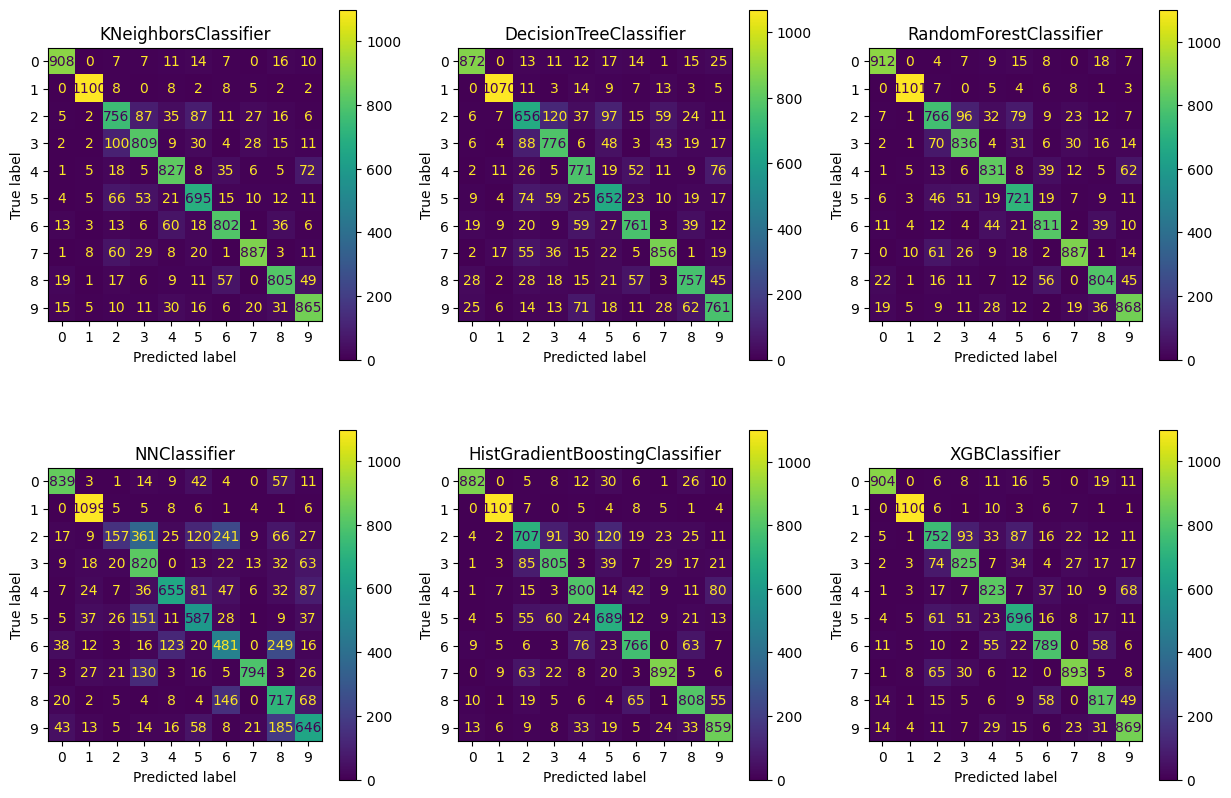

In [13]:
cvtda.classification.classify(
    train_features_umap, train_labels, test_features_umap, test_labels
)

In [ ]:
del train_features_umap
del test_features_umap
gc.collect()

876

### Information value

In [31]:
feature_selector = cvtda.classification.InformationValueFeatureSelector(threshold = 0.25, bins = 50)

train_features_selected = feature_selector.fit_transform(train_features_scaled, train_labels)
test_features_selected = feature_selector.transform(test_features_scaled)

train_features_selected.shape

Fitting the information value feature selector


information values: 100%|██████████| 10660/10660 [10:08<00:00, 17.53it/s]


Fitting complete


(60000, 6396)

<Axes: >

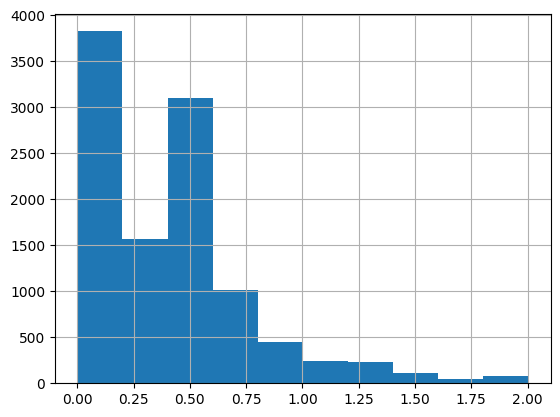

In [32]:
feature_selector.hist()

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(max_features=0.1, random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x0000019F81250B20>


100%|██████████| 50/50 [05:06<00:00,  6.13s/it, loss=8.96e+4]


Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.8693,0.9430,0.9638,0.9747,0.9815,0.9872,0.9924,0.9970,0.9991,0.977675,0.869690,0.867497,0.867280
1,DecisionTreeClassifier,0.8457,0.8680,0.8993,0.9133,0.9284,0.9466,0.9629,0.9837,0.9887,0.913416,0.843584,0.844149,0.843679
2,RandomForestClassifier,0.9199,0.9678,0.9828,0.9901,0.9936,0.9970,0.9990,0.9997,0.9999,0.994069,0.919271,0.918697,0.918833
3,NNClassifier,0.9330,0.9730,0.9855,0.9913,0.9956,0.9981,0.9988,0.9996,0.9999,0.995022,0.932181,0.932246,0.932111
4,HistGradientBoostingClassifier,0.8933,0.9568,0.9766,0.9857,0.9929,0.9957,0.9976,0.9990,0.9996,0.991147,0.892040,0.891886,0.891826
5,XGBClassifier,0.9146,0.9688,0.9850,0.9922,0.9963,0.9977,0.9989,0.9994,0.9997,0.994245,0.913462,0.913427,0.913369


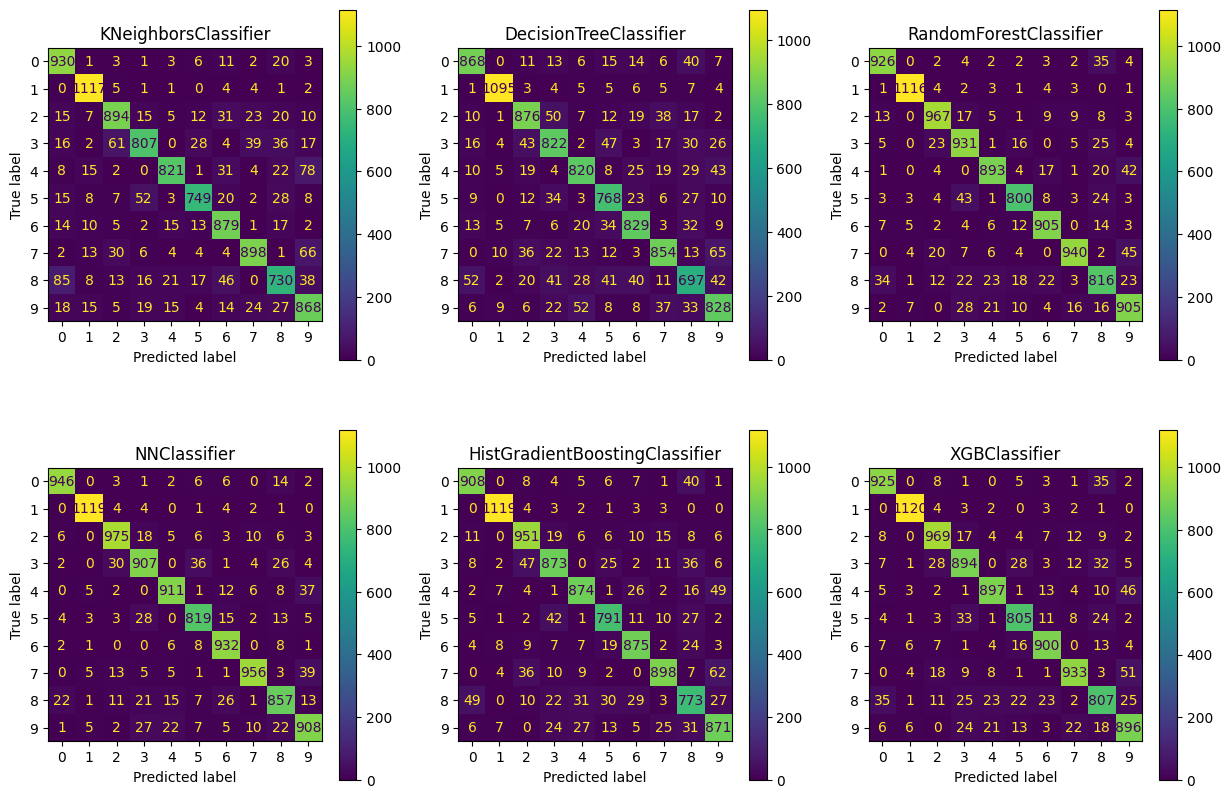

In [33]:
cvtda.classification.classify(
    train_features_selected, train_labels, test_features_selected, test_labels
)

In [44]:
del train_features_selected
del test_features_selected
gc.collect()

7

### Correlation selector

/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(array([4.436e+03, 0.000e+00, 0.000e+00, 4.000e+00, 3.140e+02, 9.970e+02,
        4.360e+03, 4.432e+03, 6.293e+03, 4.840e+02]),
 array([-1.        , -0.85125984, -0.70251969, -0.55377953, -0.40503937,
        -0.25629921, -0.10755906,  0.0411811 ,  0.18992126,  0.33866142,
         0.48740157]),
 <BarContainer object of 10 artists>)

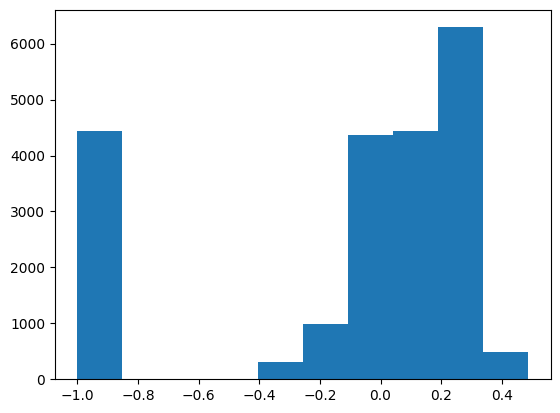

In [ ]:
import matplotlib.pyplot as plt

plt.hist(cvtda.classification.correlate_with_target(train_features, train_labels))

In [84]:
feature_selector = cvtda.classification.CorrelationSelector(threshold = -0.1)

train_features_selected = feature_selector.fit_transform(train_features, train_labels)
test_features_selected = feature_selector.transform(test_features)

train_features_selected.shape

Fitting the correlations feature selector


/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fitting complete


(1000, 15498)

In [85]:
import sklearn.preprocessing

selected_standard_scaler = sklearn.preprocessing.StandardScaler()
train_features_selected_scaled = selected_standard_scaler.fit_transform(train_features_selected)
test_features_selected_scaled = selected_standard_scaler.transform(test_features_selected)

train_features_selected_scaled.shape

(1000, 15498)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x3c53de050>


100%|██████████| 100/100 [00:23<00:00,  4.24it/s, loss=1.49e+3]


Fitting HistGradientBoostingClassifier(max_depth=4, max_iter=25, random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.856,0.924,0.964,0.976,0.980,0.980,0.984,0.992,1.0,0.969500,0.864040,0.848446,0.847093
1,DecisionTreeClassifier,0.836,0.884,0.904,0.916,0.928,0.948,0.948,0.992,1.0,0.900281,0.829266,0.820505,0.819736
2,RandomForestClassifier,0.908,0.964,0.984,0.988,0.992,0.996,0.996,1.000,1.0,0.994893,0.904912,0.904496,0.903603
3,NNClassifier,0.924,0.952,0.956,0.960,0.964,0.968,0.972,0.988,1.0,0.983467,0.920340,0.920155,0.918619
4,HistGradientBoostingClassifier,0.916,0.956,0.976,0.988,0.988,0.992,0.992,0.996,1.0,0.992572,0.909219,0.910433,0.908495
5,XGBClassifier,0.920,0.960,0.964,0.984,0.988,0.988,0.996,0.996,1.0,0.993481,0.910374,0.914311,0.910409


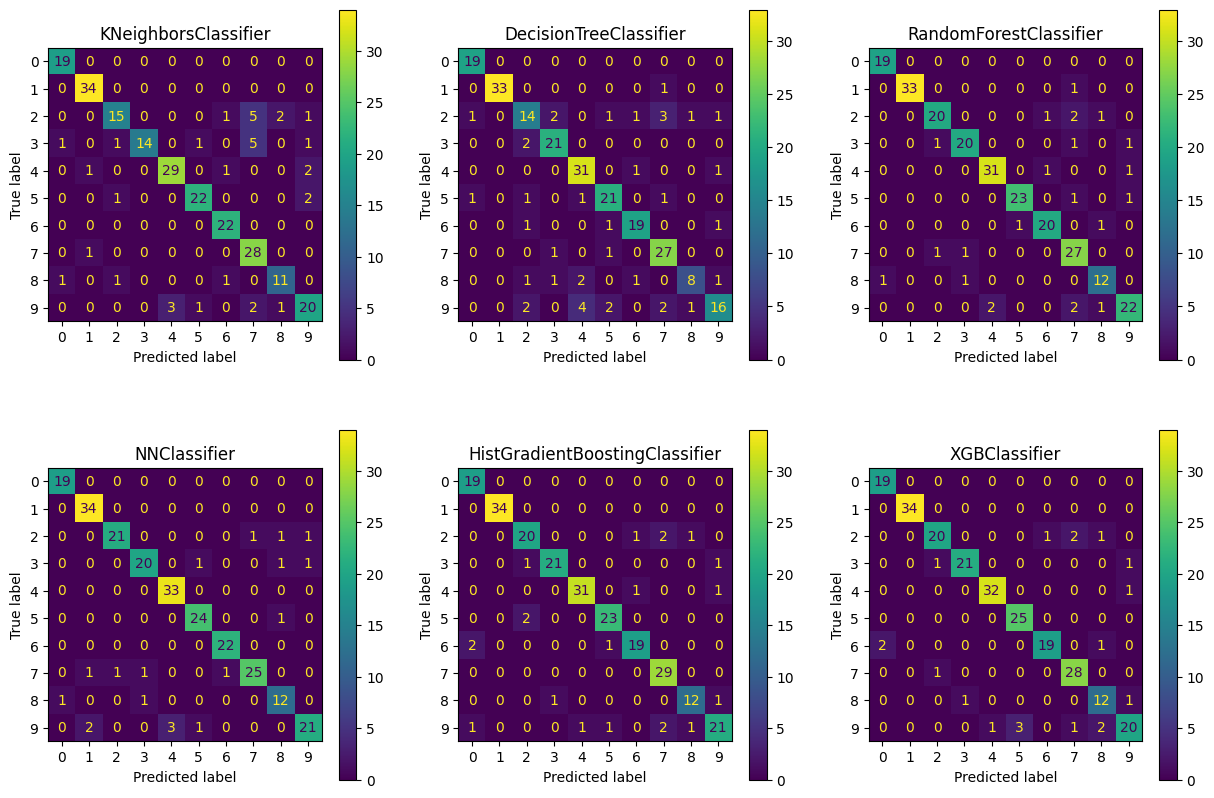

In [86]:
cvtda.classification.classify(
    train_features_selected_scaled, train_labels, test_features_selected_scaled, test_labels,
    nn_device = 'mps', nn_epochs = 100, nn_batch_size = 64
)

### Remove duplicates

In [6]:
import numpy

train_features = numpy.minimum(
    numpy.hstack([
        numpy.load("6/raw_images/train_features.npy"),
        numpy.load("6/inverted/train_features.npy"),
        numpy.load("6/sobel/train_features.npy")
    ]),
    1e9
)
test_features = numpy.minimum(
    numpy.hstack([
        numpy.load("6/raw_images/test_features.npy"),
        numpy.load("6/inverted/test_features.npy"),
        numpy.load("6/sobel/test_features.npy")
    ]),
    1e9
)

train_features.shape, test_features.shape

((60000, 31720), (10000, 31720))

In [7]:
import sklearn.feature_selection

t = sklearn.feature_selection.VarianceThreshold(threshold = 1e-5)
train_features = t.fit_transform(train_features)
test_features = t.transform(test_features)

In [8]:
train_features.shape, test_features.shape

((60000, 24968), (10000, 24968))

In [9]:
import sklearn.preprocessing

standard_scaler = sklearn.preprocessing.StandardScaler()
train_features_scaled = standard_scaler.fit_transform(train_features)
test_features_scaled = standard_scaler.transform(test_features)

In [10]:
del train_features
del test_features

In [11]:
import cvtda.classification

feature_selector = cvtda.classification.InformationValueFeatureSelector(threshold = 0.5, bins = 50)

train_features_selected = feature_selector.fit_transform(train_features_scaled, train_labels)
test_features_selected = feature_selector.transform(test_features_scaled)

train_features_selected.shape

Fitting the information value feature selector


information values: 100%|██████████| 24968/24968 [03:48<00:00, 109.28it/s]


Fitting complete


(60000, 14772)

<Axes: >

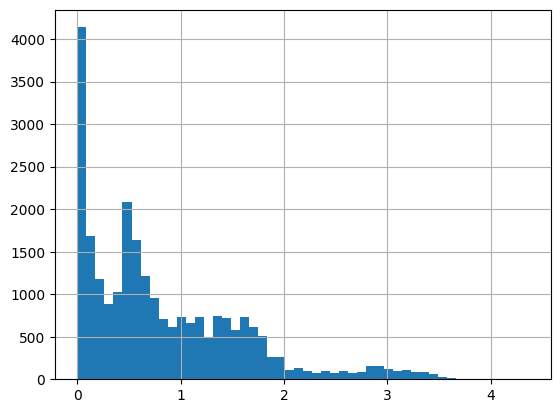

In [12]:
feature_selector.hist()

In [13]:
del train_features_scaled
del test_features_scaled
gc.collect()

96

In [16]:
feature_selector = cvtda.classification.CorrelationSelector(threshold = -0.1)

train_features_selected = feature_selector.fit_transform(train_features_selected, train_labels)
test_features_selected = feature_selector.transform(test_features_selected)

train_features_selected.shape

Fitting the correlations feature selector
Fitting complete


(60000, 13032)

(array([  72.,  115.,  392., 1056., 2327., 3865., 1695., 3254., 1956.,
          40.]),
 array([-0.52284801, -0.41903144, -0.31521486, -0.21139828, -0.1075817 ,
        -0.00376513,  0.10005145,  0.20386803,  0.3076846 ,  0.41150118,
         0.51531776]),
 <BarContainer object of 10 artists>)

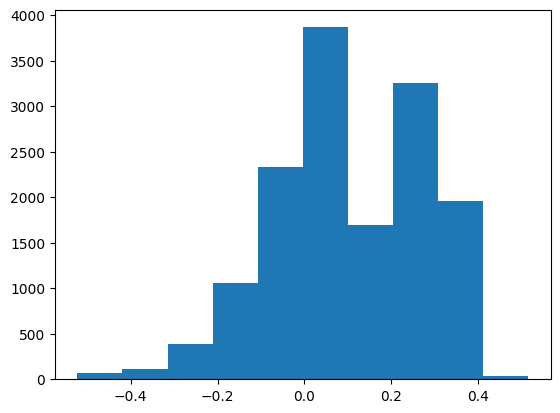

In [17]:
feature_selector.hist()

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x000002144BDA94E0>


100%|██████████| 50/50 [10:38<00:00, 12.77s/it, loss=8.8e+4] 


Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)
Fitting <catboost.core.CatBoostClassifier object at 0x000002144BDA9570>
Learning rate set to 0.321004
0:	lear

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.9502,0.9803,0.9875,0.9910,0.9933,0.9949,0.9968,0.9980,0.9991,0.993618,0.950313,0.949583,0.949745
1,RandomForestClassifier,0.9737,0.9917,0.9960,0.9975,0.9982,0.9990,0.9997,0.9997,0.9999,0.999193,0.973713,0.973337,0.973499
2,NNClassifier,0.9802,0.9936,0.9966,0.9981,0.9990,0.9993,0.9996,1.0000,1.0000,0.999323,0.980096,0.980039,0.980042
3,HistGradientBoostingClassifier,0.9670,0.9887,0.9949,0.9974,0.9982,0.9991,0.9996,0.9997,0.9999,0.998994,0.966921,0.966594,0.966730
4,XGBClassifier,0.9770,0.9940,0.9972,0.9982,0.9992,0.9998,0.9998,1.0000,1.0000,0.999558,0.976978,0.976707,0.976835
5,CatBoostClassifier,0.9782,0.9942,0.9982,0.9990,0.9998,0.9999,1.0000,1.0000,1.0000,0.999662,0.978162,0.977984,0.978062


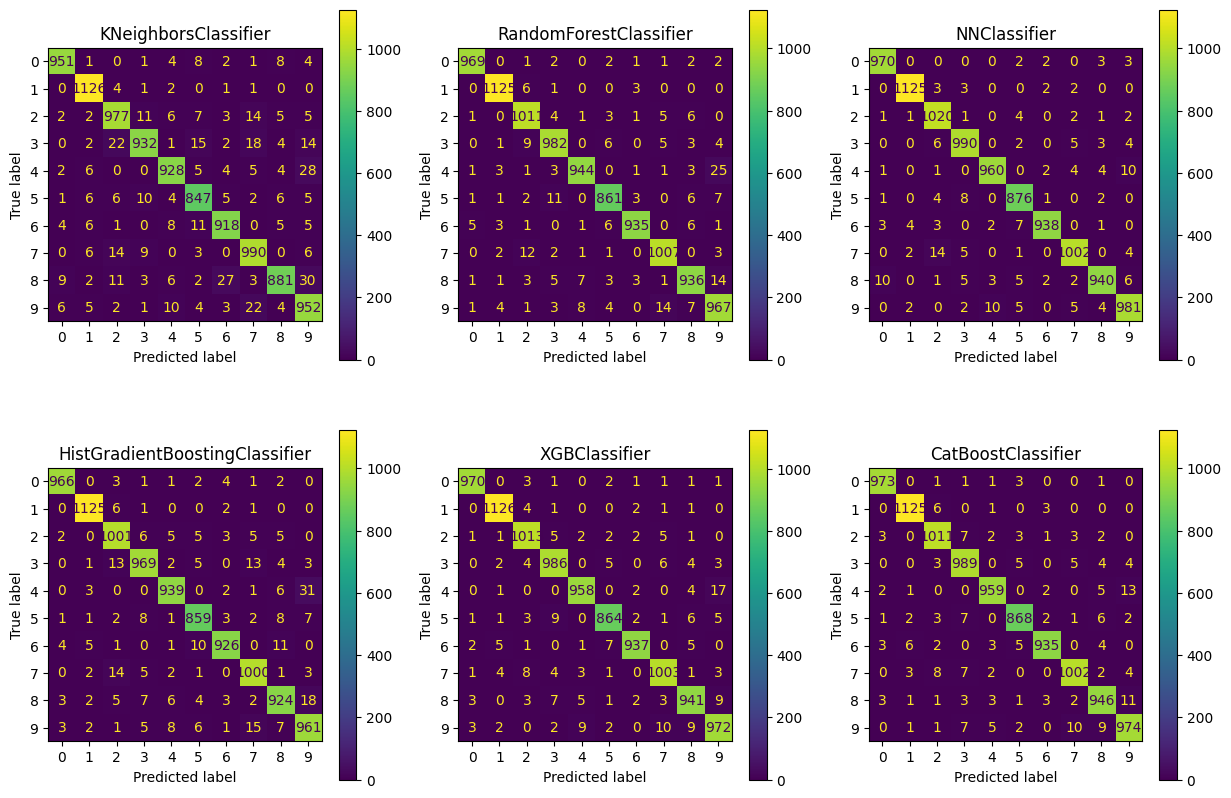

In [18]:
cvtda.classification.classify(
    train_features_selected, train_labels, test_features_selected, test_labels
)

In [12]:
import catboost

cf = catboost.CatBoostClassifier(
    # iterations = 1000,
    # depth = 4,
    random_seed = 42,
    loss_function = 'MultiClass',
    devices = '0-3',
    task_type = 'GPU',
    verbose = True
).fit(train_features_selected, train_labels)

Learning rate set to 0.149633
0:	learn: 1.6014697	total: 939ms	remaining: 15m 37s
1:	learn: 1.2587944	total: 1.78s	remaining: 14m 46s
2:	learn: 1.0568485	total: 2.58s	remaining: 14m 18s
3:	learn: 0.9217753	total: 3.34s	remaining: 13m 50s
4:	learn: 0.8117655	total: 4.2s	remaining: 13m 56s
5:	learn: 0.7256808	total: 4.99s	remaining: 13m 45s
6:	learn: 0.6525257	total: 5.94s	remaining: 14m 2s
7:	learn: 0.5942868	total: 6.87s	remaining: 14m 11s
8:	learn: 0.5421689	total: 7.8s	remaining: 14m 18s
9:	learn: 0.4968235	total: 8.75s	remaining: 14m 26s
10:	learn: 0.4633392	total: 9.49s	remaining: 14m 13s
11:	learn: 0.4282620	total: 10.4s	remaining: 14m 19s
12:	learn: 0.3975241	total: 11.4s	remaining: 14m 24s
13:	learn: 0.3696854	total: 12.4s	remaining: 14m 30s
14:	learn: 0.3481607	total: 13.3s	remaining: 14m 30s
15:	learn: 0.3292993	total: 14.1s	remaining: 14m 28s
16:	learn: 0.3117945	total: 15s	remaining: 14m 27s
17:	learn: 0.2937676	total: 15.9s	remaining: 14m 28s
18:	learn: 0.2793651	total: 16.

{'Accuracy': 0.9829,
 'TOP-2 Accuracy': 0.9965,
 'TOP-3 Accuracy': 0.9993,
 'TOP-4 Accuracy': 0.9997,
 'TOP-5 Accuracy': 0.9999,
 'TOP-6 Accuracy': 0.9999,
 'TOP-7 Accuracy': 1.0,
 'TOP-8 Accuracy': 1.0,
 'TOP-9 Accuracy': 1.0,
 'AUC-ROC': 0.9998044142072877,
 'Precision': 0.9828380115571127,
 'Recall': 0.982736837924301,
 'F1-score': 0.9827773288972388}

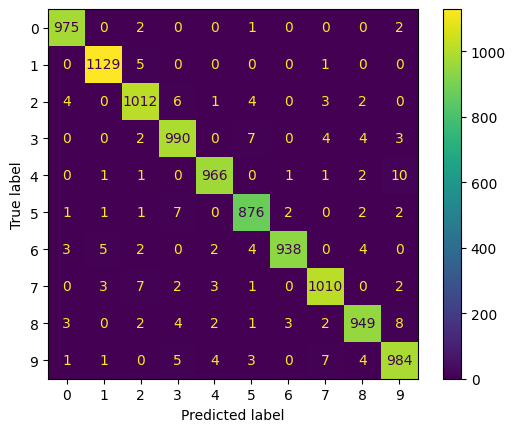

In [13]:
import cvtda.classification

cvtda.classification.estimate_quality(cf.predict_proba(test_features_selected), test_labels)

In [19]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 128, random_state = 42)

train_features_pca = pca.fit_transform(train_features_selected)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])

test_features_pca = pca.transform(test_features_selected)

Explained variance 0.94
[0.353, 0.11, 0.091, 0.05, 0.038, 0.034, 0.023, 0.019, 0.015, 0.013, 0.012, 0.01, 0.009, 0.008, 0.007, 0.007, 0.006, 0.006, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x000002144B38B9D0>


100%|██████████| 50/50 [00:21<00:00,  2.32it/s, loss=8.81e+4]


Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)
Fitting <catboost.core.CatBoostClassifier object at 0x000002144B3893F0>
Learning rate set to 0.321004
0:	lear

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.9489,0.9787,0.9869,0.9899,0.9926,0.9941,0.9965,0.9979,0.9991,0.993111,0.948879,0.948293,0.948449
1,RandomForestClassifier,0.9448,0.9791,0.9890,0.9933,0.9963,0.9981,0.9990,0.9997,0.9998,0.997221,0.944633,0.944246,0.944314
2,NNClassifier,0.9770,0.9918,0.9961,0.9979,0.9984,0.9992,0.9994,0.9996,1.0000,0.999337,0.976947,0.976791,0.976845
3,HistGradientBoostingClassifier,0.9074,0.9586,0.9767,0.9871,0.9920,0.9962,0.9977,0.9989,0.9998,0.993196,0.907444,0.906526,0.906621
4,XGBClassifier,0.9360,0.9769,0.9880,0.9939,0.9959,0.9975,0.9982,0.9991,0.9997,0.997026,0.935921,0.935369,0.935571
5,CatBoostClassifier,0.9669,0.9899,0.9953,0.9976,0.9987,0.9992,0.9997,0.9997,0.9999,0.999191,0.966740,0.966572,0.966632


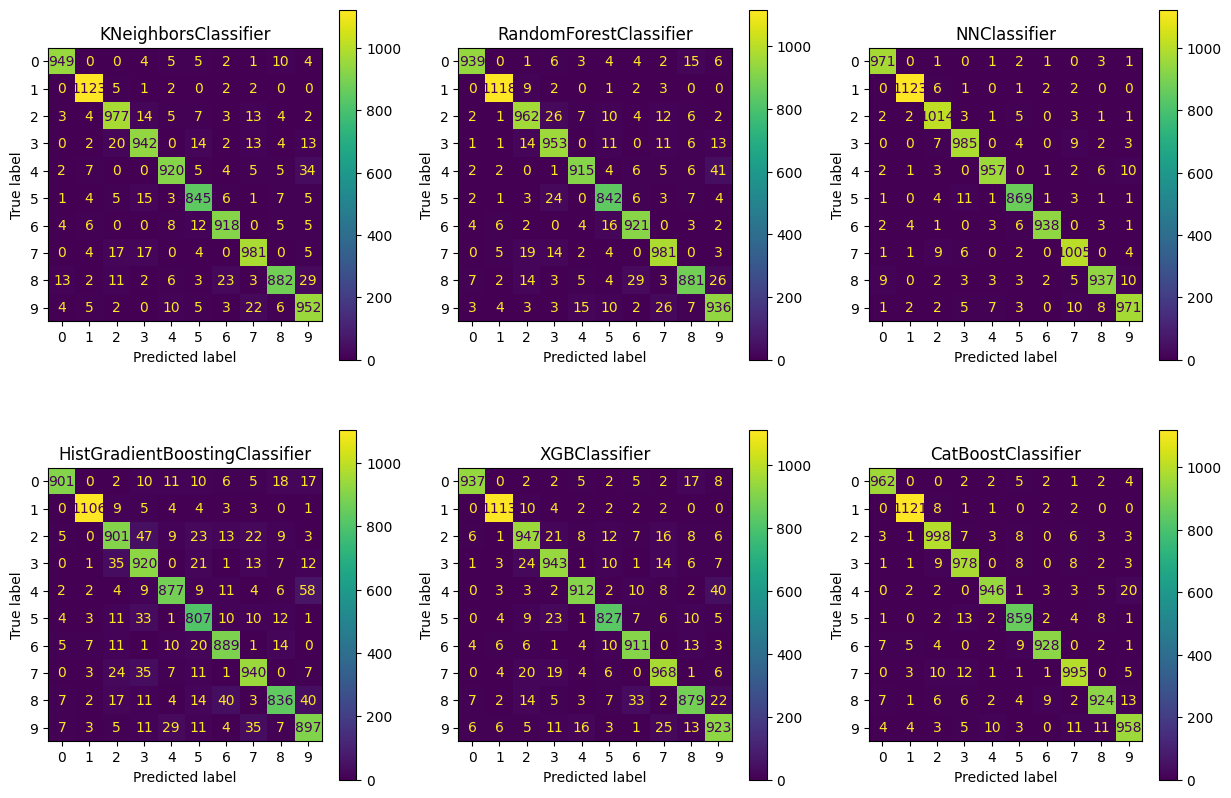

In [20]:
cvtda.classification.classify(
    train_features_pca, train_labels, test_features_pca, test_labels
)

In [153]:
import tqdm

TOLERANCE = 1e-8

def find_duplicate_columns(features: numpy.ndarray) -> set:
    duplicates = set()
    features = features.transpose()
    for i in range(features.shape[0]):
        if i in duplicates:
            continue
        comp = numpy.abs(features - features[i]) < TOLERANCE
        comp = numpy.sum(comp, axis = 1)
        comp = numpy.where(comp == features.shape[1])[0]
        for j in comp[1:]:
            duplicates.add(j)
    return duplicates

def find_non_duplicates(features: numpy.ndarray):
    duplicates = set()

    partition_by = numpy.random.randint(low = 0, high = features.shape[0])
    partition_item = features[partition_by, :]
    for partition_value in tqdm.tqdm(numpy.unique(partition_item)):
        partition_idxs = numpy.where(numpy.abs(partition_item - partition_value) < TOLERANCE)[0]
        partition_idxs = numpy.setdiff1d(partition_idxs, numpy.array(list(duplicates)), assume_unique = True)

        partition_duplicates = list(find_duplicate_columns(features[:, partition_idxs]))
        for item in partition_idxs[partition_duplicates]:
            duplicates.add(item)

    print(f'Found {len(duplicates)} duplicates')
    return list(set(range(features.shape[1])) - duplicates)
    
non_duplicates = find_non_duplicates(train_features_selected)
len(non_duplicates)

100%|██████████| 8018/8018 [00:20<00:00, 386.03it/s]

Found 5264 duplicates


7768

In [154]:
train_features_selected = train_features_selected[:, non_duplicates]
test_features_selected = test_features_selected[:, non_duplicates]

train_features_selected.shape, test_features_selected.shape

((60000, 7768), (10000, 7768))

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x00000214764B4D90>


100%|██████████| 50/50 [06:06<00:00,  7.33s/it, loss=8.8e+4] 


Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)
Fitting <catboost.core.CatBoostClassifier object at 0x00000214764B42E0>
Learning rate set to 0.321004
0:	lear

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.9530,0.9814,0.9883,0.9921,0.9937,0.9951,0.9970,0.9981,0.9991,0.993910,0.953100,0.952384,0.952574
1,RandomForestClassifier,0.9726,0.9920,0.9963,0.9970,0.9980,0.9989,0.9996,0.9999,1.0000,0.999203,0.972628,0.972253,0.972419
2,NNClassifier,0.9795,0.9940,0.9978,0.9986,0.9995,0.9997,0.9998,1.0000,1.0000,0.999215,0.979724,0.979164,0.979414
3,HistGradientBoostingClassifier,0.9665,0.9893,0.9957,0.9980,0.9988,0.9992,0.9994,0.9997,1.0000,0.999033,0.966451,0.966083,0.966238
4,XGBClassifier,0.9765,0.9934,0.9974,0.9986,0.9989,0.9992,0.9997,1.0000,1.0000,0.999539,0.976460,0.976187,0.976314
5,CatBoostClassifier,0.9785,0.9945,0.9978,0.9991,0.9998,0.9999,1.0000,1.0000,1.0000,0.999672,0.978494,0.978294,0.978380


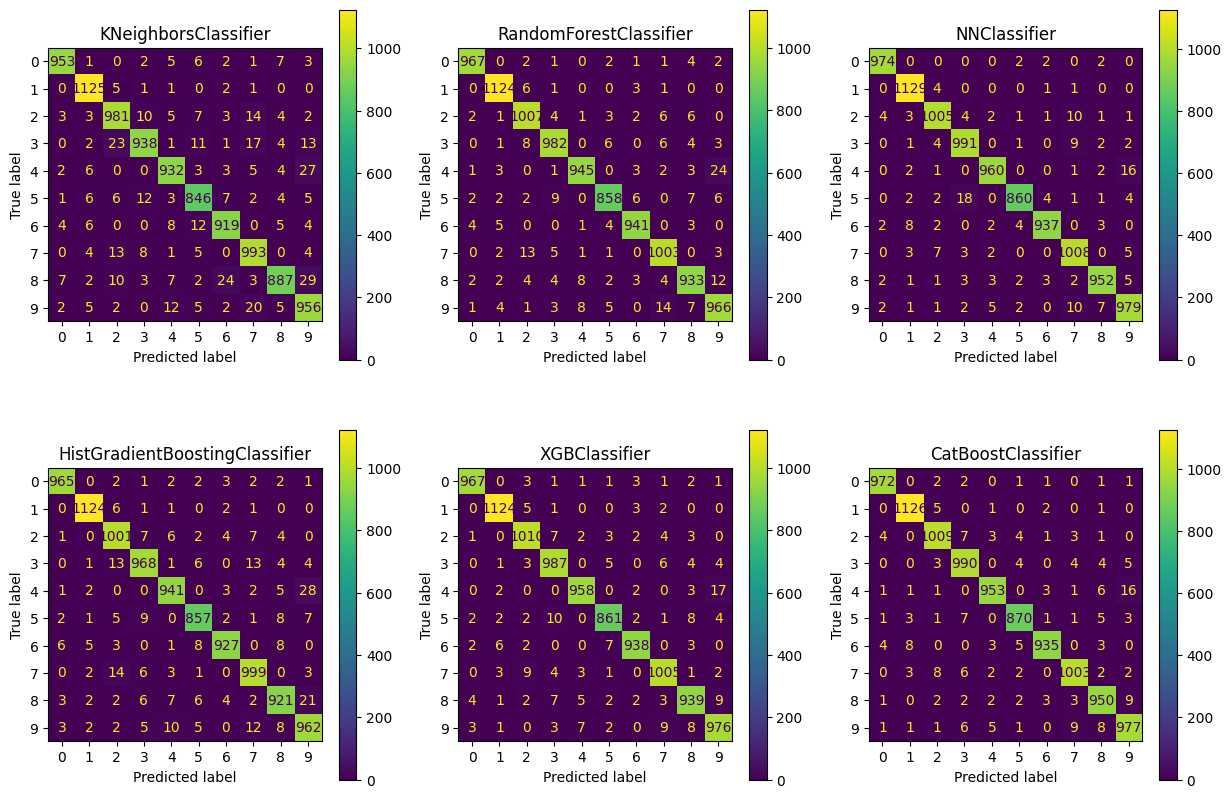

In [156]:
cvtda.classification.classify(
    train_features_selected, train_labels, test_features_selected, test_labels
)

In [155]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 128, random_state = 42)

train_features_pca = pca.fit_transform(train_features_selected)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])

test_features_pca = pca.transform(test_features_selected)

Explained variance 0.93
[0.331, 0.115, 0.086, 0.052, 0.041, 0.033, 0.023, 0.018, 0.016, 0.014, 0.012, 0.01, 0.01, 0.008, 0.007, 0.007, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x000002147545FDC0>


100%|██████████| 50/50 [00:21<00:00,  2.34it/s, loss=8.81e+4]


Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)
Fitting <catboost.core.CatBoostClassifier object at 0x000002144B564580>
Learning rate set to 0.321004
0:	lear

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.9523,0.9801,0.9881,0.9908,0.9932,0.9941,0.9963,0.9981,0.9991,0.993475,0.952295,0.951761,0.951908
1,RandomForestClassifier,0.9469,0.9785,0.9879,0.9932,0.9958,0.9977,0.9984,0.9992,0.9997,0.997072,0.946779,0.946412,0.946505
2,NNClassifier,0.9767,0.9927,0.9964,0.9983,0.9988,0.9990,0.9995,0.9998,1.0000,0.999402,0.976665,0.976522,0.976586
3,HistGradientBoostingClassifier,0.9053,0.9563,0.9770,0.9863,0.9915,0.9955,0.9977,0.9992,0.9995,0.992917,0.905751,0.904382,0.904679
4,XGBClassifier,0.9389,0.9773,0.9890,0.9936,0.9967,0.9979,0.9991,0.9996,0.9999,0.997368,0.938721,0.938409,0.938472
5,CatBoostClassifier,0.9697,0.9903,0.9959,0.9977,0.9986,0.9993,0.9997,0.9999,1.0000,0.999270,0.969653,0.969260,0.969423


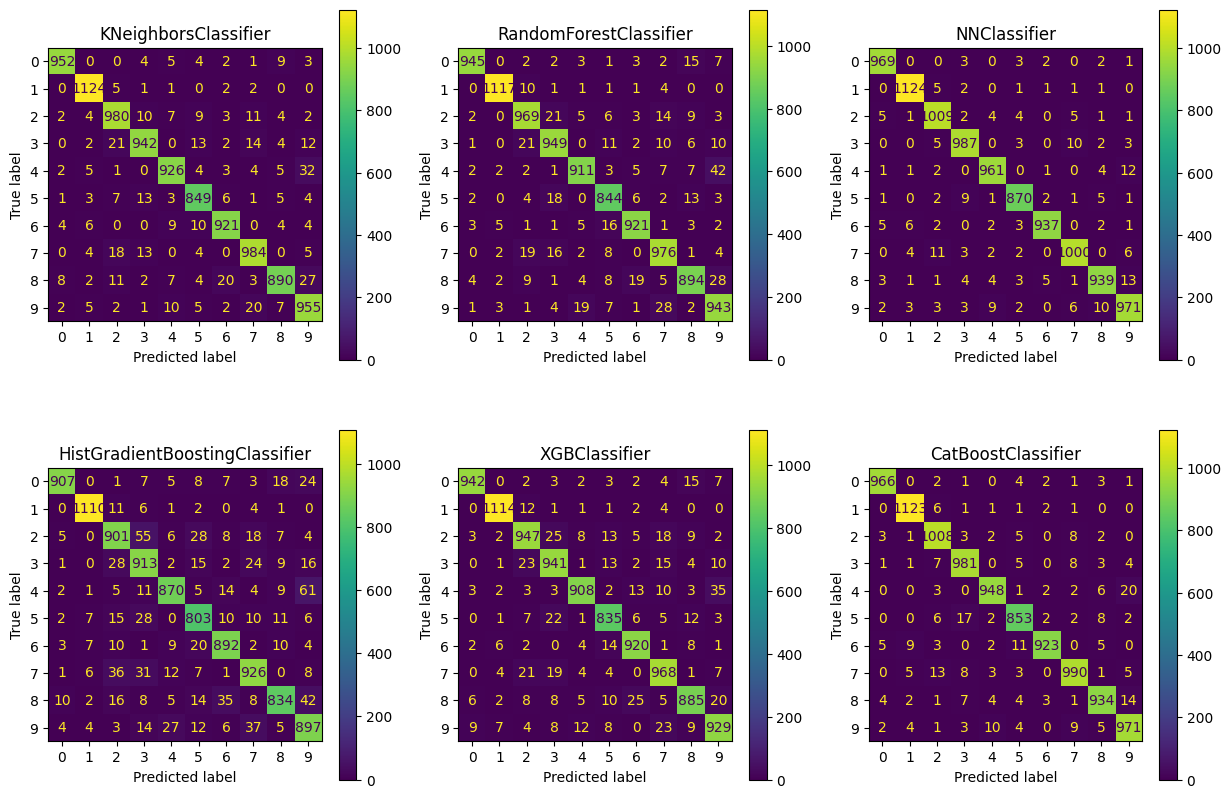

In [158]:
cvtda.classification.classify(
    train_features_pca, train_labels, test_features_pca, test_labels
)